In [11]:
%load_ext autoreload
%autoreload 2
from util import *
from ArcExpression import get_Arc_expression, normalize_Arc, normalize_IEG, get_IEG_cells

from scipy import stats
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
proj_meta = load_meta()

Text(0.5,1,'Arc distribution by timepoint')

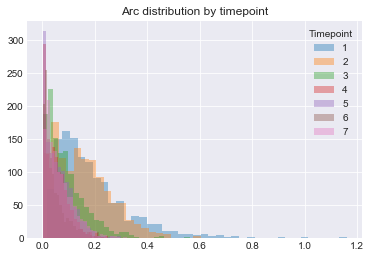

In [3]:
figsize = (16,12)
tps = np.int32(np.linspace(0, 12, 7))
ieg_levs = {}
cnt = 0
ieg_inds = [range(4), range(4,9)]
for cond in range(len(tps)):
    arc_levs = []
#     arc_levs.append(
#             [normalize_Arc(get_Arc_expression(proj_meta, site, tps[cond]))
#             for site in range(4)])
    arc_levs.append([
        normalize_IEG(proj_meta, site, tps[cond]) for site in range(4)
    ])
#     ieg_levs[cnt] = np.hstack(np.hstack(np.mean(arc_levs, axis=1)))
    ieg_levs[cnt] = np.mean(np.vstack(np.hstack(arc_levs)), axis=1)

    sns.distplot(ieg_levs[cnt], label="{}".format(cond+1), kde=False)
    cnt += 1

plt.legend(title="Timepoint");
plt.title("Arc distribution by timepoint")

### Grouping by "early" and "late' sessions 

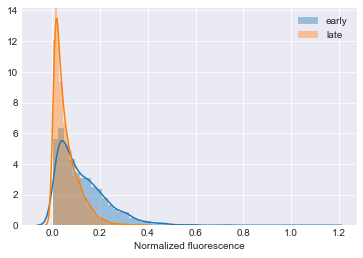

In [4]:
tmp_early = np.hstack((ieg_levs[1], ieg_levs[2]))
tmp_late = np.hstack((ieg_levs[5], ieg_levs[6]))
sns.distplot(tmp_early, label="early")
sns.distplot(tmp_late, label="late")
plt.legend()
plt.xlabel("Normalized fluorescence");

### Within-session dynamics

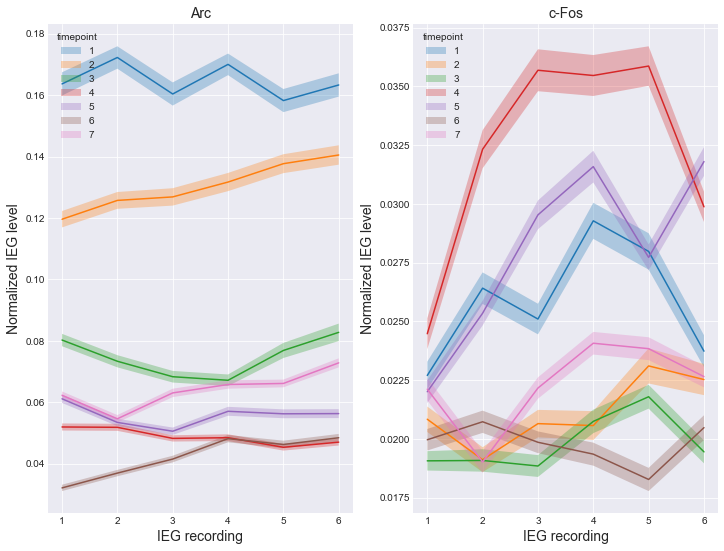

In [9]:
plt.figure(figsize=(12,9))
tps = np.int32(np.linspace(0, 12, 7))

inds = [range(5), range(5,9)]
titles = ["Arc", "c-Fos"]

for ind in range(2):
    plt.subplot(1,2,ind+1)
    cum_arc = []
    cnt = 0
    for tp in tps:
        tmp = [normalize_IEG(proj_meta, site, tp) for site in inds[ind]]
#         tmp = [normalize_Arc(get_Arc_expression(proj_meta, site, tp), keep_res=True)
#                for site in inds[ind]]
        cum_arc.append(np.vstack(tmp))
        cnt += 1

    cnt = 0
    for tp in tps:
        err = sem(cum_arc[cnt])
        mn = (np.mean(cum_arc[cnt], axis=0)) 
        x = range(1,7)
        plt.fill_between(x, mn-err, mn+err, alpha=0.3,
                        label="{}".format(cnt+1))
        plt.plot(x, mn)
        cnt += 1
    plt.title(titles[ind], fontsize=14)
    plt.xlabel("IEG recording", fontsize=14)
    plt.ylabel("Normalized IEG level", fontsize=14)
#     plt.ylim([1.005, 1.1])
    plt.legend(loc="upper left", title="timepoint");

In [456]:
tmp_arc = np.vstack([np.mean(k, axis=1) for k in cum_arc])

In [457]:
tmp = cum_arc[6]-cum_arc[0]

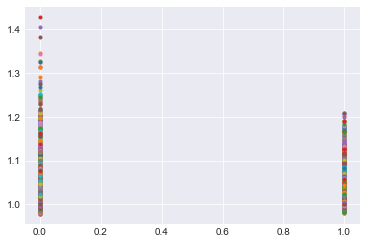

In [458]:
plt.plot([cum_arc[0].flatten(), cum_arc[6].flatten()],'.');

### Selecting cells by IEG level




### Selecting the top X% for each animal 

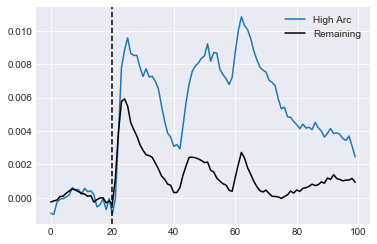

In [32]:
from ArcExpression import get_IEG_cells

thresh = 90 # Percentile cutoff for choosing cells
arc_Act = []
rem_Act = []
for site in range(4,9):
    # Choose IEG-hi cells
    ieg_cells = get_IEG_cells(proj_meta, site, thresh=thresh)
    
    tone_act = np.hstack(tone_responses(proj_meta, site, 13, 20, 80))
    tone_act = elemwise_subtract(tone_act, np.mean(tone_act[:,:,10:19], axis=2))
    
    # Remaining ("non-IEG") cells
    rem_cells = np.setdiff1d(np.arange(tone_act.shape[0]), ieg_cells)
    
    arc_Act.append(np.mean(tone_act[ieg_cells,:,:], axis=1))
    rem_Act.append(np.mean(tone_act[rem_cells,:,:], axis=1))
      
ieg_Act = np.vstack(arc_Act)
misc_Act = np.vstack(rem_Act)

plt.plot(np.mean(ieg_Act, axis=0), label="High Arc")
plt.plot(np.mean(misc_Act, axis=0),'k', label="Remaining")
plt.legend()
plt.axvline(20, color="k", linestyle="--");

### With the global top X%

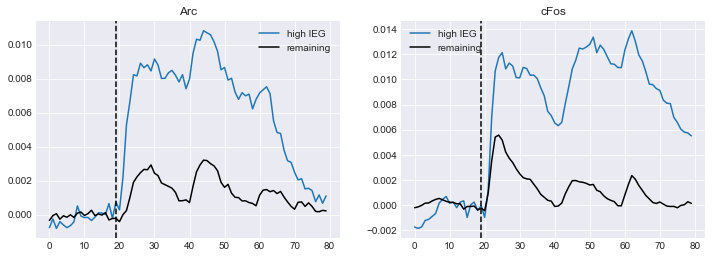

In [448]:
ieg_ranges = (range(4), range(4,9))
plt.figure(figsize=(12,4))
titles = ["Arc", "cFos"]
tps = np.int32(np.linspace(0, 12, 7)) # IEG Timepoints

tp_tested = 13 # Timepoint where tone activity is interrogated

tot_ieg_act = []
tot_rem_act = []
hi_tone_act = []
rem_tone_act = []
for ieg_ind in range(2):
    mn_ieg = []
    mn_act = []
    plt.subplot(1,2,ieg_ind+1)
    for site in ieg_ranges[ieg_ind]:
        cum_arc = np.vstack([np.mean(normalize_Arc(
            get_Arc_expression(proj_meta, site, tp),
                     keep_res=True), axis=1) for tp in tps])
        # get tone responses
        tone_act = np.hstack(tone_responses(proj_meta, site, tp=tp_tested,
                                            win_pre=20, win_post=60))
        # mean-subtract
#         tone_act = elemwise_subtract(tone_act, np.mean(tone_act[:,:,10:18], axis=2))

        # Decide how to select high arc cells    
        mn_ieg.append(np.mean(cum_arc[1:2,:], axis=0))      
        mn_act.append(np.mean(tone_act, axis=1))
    
    mn_ieg = np.hstack(mn_ieg)
    mn_act = np.vstack(mn_act)
    mn_act = elemwise_subtract(mn_act, np.mean(mn_act[:,10:18], axis=1))

    # Get cells at certain percentile of IEG expression
    IEG_cells = np.where(mn_ieg >= np.percentile(mn_ieg, 90))[0]
    rem_cells = np.setdiff1d(np.arange(mn_act.shape[0]), IEG_cells)
    
    mnact_onset = np.mean(mn_act[:,24:29], axis=1)
    
    tone_cells = np.where(mnact_onset >= np.percentile(mnact_onset, 90))[0]
    rem_tone_cells = np.setdiff1d(np.arange(mn_act.shape[0]), tone_cells)


    ieg_act = mn_act[IEG_cells,:]
    rem_act = mn_act[rem_cells,:]
    
    tone_hi_act = mn_act[tone_cells,:]
    tone_rem_act = mn_act[rem_tone_cells,:]
    
    # This is for both IEGs
    tot_ieg_act.append(ieg_act)
    tot_rem_act.append(rem_act)
    hi_tone_act.append(tone_hi_act)
    rem_tone_act.append(tone_rem_act)
    # --------------------------- 

    plt.plot(np.mean(ieg_act,axis=0), label="high IEG")
    plt.plot(np.mean(rem_act,axis=0),color="k", label="remaining")
    plt.axvline(19, color="k", linestyle="--")
    plt.legend()
    plt.title(titles[ieg_ind])

In [443]:
mn_act.shape

(1819, 40)

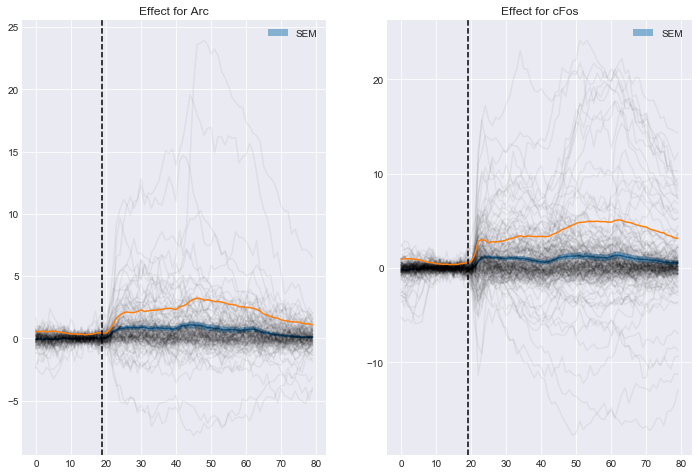

In [449]:
titles = ["Arc", "cFos"]
plt.figure(figsize=(12,8))
for ind in range(2):
    plt.subplot(1,2,ind+1)
    tmp_act = tot_ieg_act[ind]
#     tmp_act = tmp_act[clean_inds(tmp_act),:]
    mn, std = np.mean(100*tmp_act, axis=0), np.std(100*tmp_act, axis=0)
    sem = std / np.sqrt(tmp_act.shape[0])
    x = np.arange(len(sem))
    plt.fill_between(x, mn-sem, mn+sem, alpha=0.5, label="SEM")
#     plt.fill_between(x, mn-std, mn+std, alpha=0.1, color='k', label="std. dev")

    plt.plot(x, mn)
    plt.plot(100*tmp_act.T, color="k", alpha=0.05)
    plt.plot(x, std)
#     plt.ylim((-3,5))
    plt.axvline(19, color="k", linestyle="--")
    plt.title('Effect for {}'.format(titles[ind]))
    plt.legend()
#     a;sl;lksdjf dskfj - plot std alone

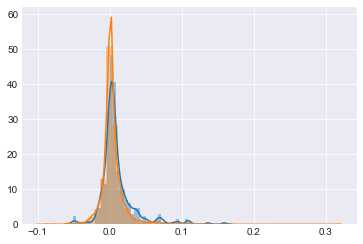

In [280]:
sns.distplot(np.mean(np.vstack(tot_ieg_act)[:,24:29], axis=1))
sns.distplot(np.mean(np.vstack(tot_rem_act)[:,24:29], axis=1))

In [303]:
# Bayesian Estimation
from Statistics import BEST, posterior_plots

trace, ppc = BEST(np.mean(np.vstack(tot_ieg_act)[:,24:29], axis=1),
             np.mean(np.vstack(tot_rem_act)[:,24:29], axis=1),
             mu_priors="Normal", variational=False)

Compiling Model
Getting MAP Estimate


logp = 4,213.3, ||grad|| = 16.495: 100%|█████| 34/34 [00:00<00:00, 1171.44it/s]


Sampling :)


Multiprocess sampling (8 chains in 8 jobs)
NUTS: [v_minus_one_log__, group2_std_interval__, group1_std_interval__, group2_mean, group1_mean]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


Done!


100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 1258.61it/s]


In [286]:
from scipy.stats import ttest_ind, ranksums
ranksums(np.mean(np.vstack(tot_ieg_act)[:,24:29], axis=1),
         np.mean(np.vstack(tot_rem_act)[:,24:29], axis=1))

RanksumsResult(statistic=5.475606414069718, pvalue=4.360158429096005e-08)

### IEG Expression per tone response

In [1]:
sns.distplot(mn_ieg[tone_cells], color="b", label="High tone cells")
sns.distplot(mn_ieg[rem_tone_cells], color="orange", label="Remaining tone cells")
plt.xlabel("IEG Expression")
plt.legend()

NameError: name 'sns' is not defined

In [251]:
mn_ieg[rem_tone_cells].shape

(1455,)

In [304]:
# Bayesian Estimation
from Statistics import BEST, posterior_plots
trace = BEST(mn_ieg[tone_cells], mn_ieg[rem_tone_cells], variational=False)

Compiling Model
Getting MAP Estimate


logp = 2,434.4, ||grad|| = 0.020855: 100%|███| 90/90 [00:00<00:00, 1290.55it/s]


Sampling :)


Multiprocess sampling (8 chains in 8 jobs)
NUTS: [v2_log__, v_minus_one_log__, group2_std_interval__, group1_std_interval__, group2_mean_interval__, group1_mean_interval__]


Done!


100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 1209.38it/s]


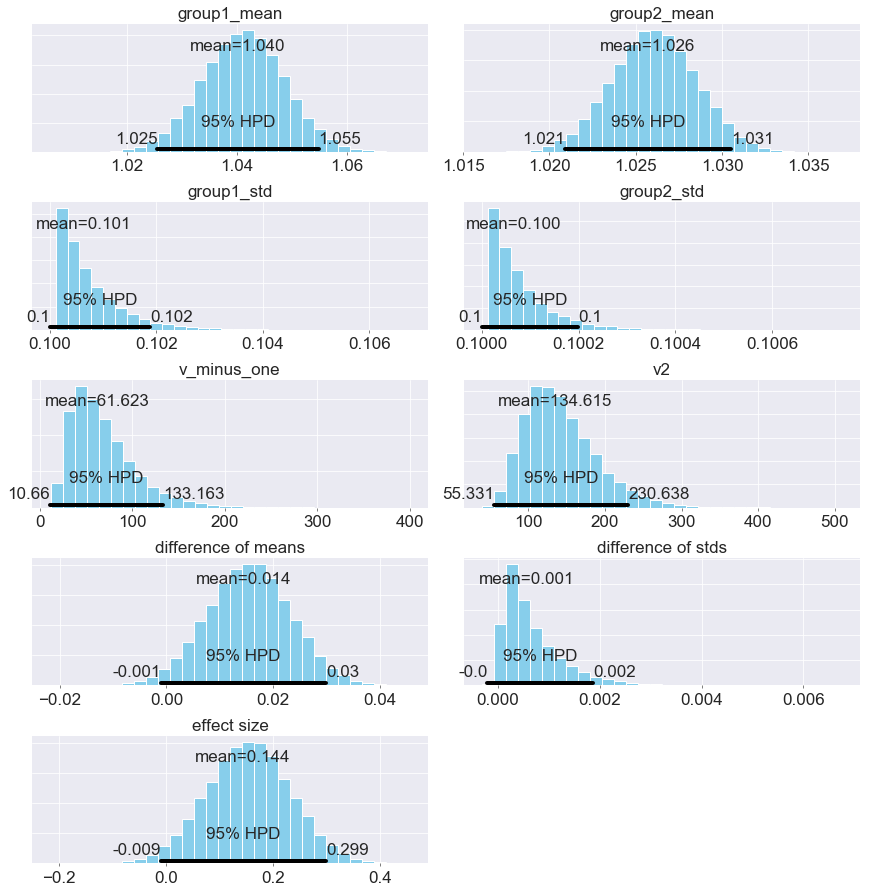

In [308]:
# trace.get_optimization_replacements
posterior_plots(trace[0], text_size=17)

In [176]:
from Statistics import BEST, posterior_plots
trace = BEST(tmp_ieg[hi_tone], tmp_ieg[rest_tone])

Compiling Model
Getting MAP Estimate


logp = 571.67, ||grad|| = 0.055396: 100%|████| 37/37 [00:00<00:00, 1434.92it/s]


Sampling :)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v_minus_one_log__, group2_std_interval__, group1_std_interval__, group2_mean_interval__, group1_mean_interval__]


Done!


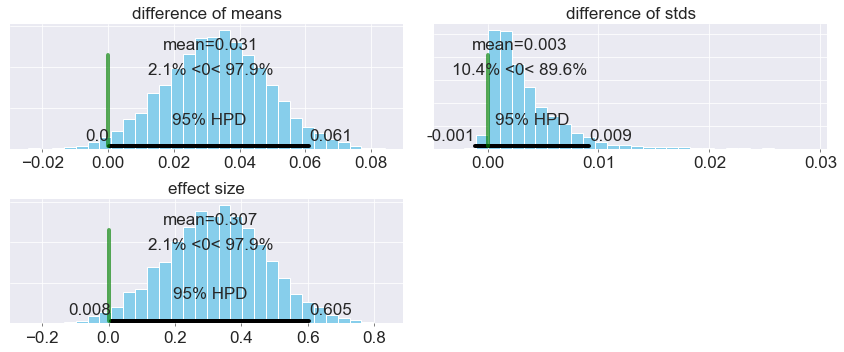

In [186]:
posterior_plots(trace, varnames=["difference of means",
                                 "difference of stds",
                                 "effect size"],
                                 text_size=17,
                                 ref_val=0);

### Plot activity levels and IEG_hi/lo difference per percentile chosen

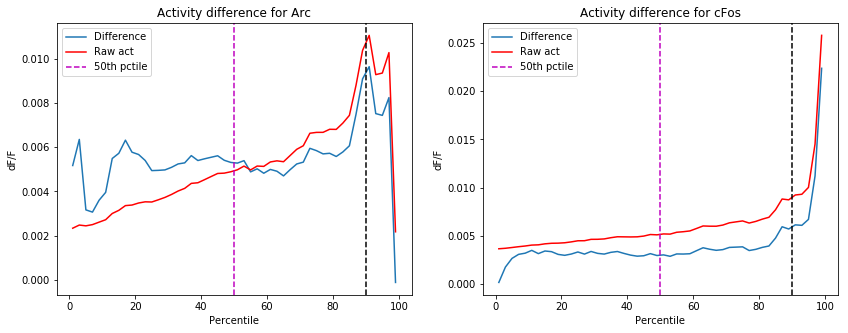

In [34]:
ieg_ranges = (range(4), range(4,9))
titles = ["Arc", "cFos"]
tps = np.int32(np.linspace(0, 12, 7)) # IEG Timepoints

tp_tested = 13 # Timepoint where tone activity is interrogated

pct_range = range(1, 100, 2) # increasing range of percentiles to check

IEG_hi = []
IEG_lo = []
for ieg_ind in range(2):
    mn_ieg = []
    mn_act = []
    for site in ieg_ranges[ieg_ind]:
        cum_arc = np.vstack([np.mean(normalize_Arc(
            get_Arc_expression(proj_meta, site, tp),
                     keep_res=True), axis=1) for tp in tps])
        # get tone responses
        tone_act = np.hstack(tone_responses(proj_meta, site, tp=tp_tested,
                                            win_pre=20, win_post=80))
        # mean-subtract
        tone_act = elemwise_subtract(tone_act, np.mean(tone_act[:,:,10:19], axis=2))

        # Decide how to select high arc cells
        mn_ieg.append(np.median(cum_arc[:,:], axis=0))
        
        mn_act.append(np.mean(tone_act, axis=1))
    
    mn_ieg = np.hstack(mn_ieg)
    mn_act = np.vstack(mn_act)
    ieg_hi_act = []
    ieg_lo_act = []
    # Get cells at certain percentile of IEG expression
    for pctile in pct_range:
        IEG_cells = np.where(mn_ieg >= np.percentile(mn_ieg, pctile))[0]
        rem_cells = np.setdiff1d(np.arange(mn_act.shape[0]), IEG_cells)
 
        ieg_hi_act.append(np.mean(mn_act[IEG_cells,:], axis=0))
        ieg_lo_act.append(np.mean(mn_act[rem_cells,:], axis=0))
                
     
    IEG_hi.append(ieg_hi_act)
    IEG_lo.append(ieg_lo_act)
    ieg_act = mn_act[IEG_cells,:]
    rem_act = mn_act[rem_cells,:]

plt.figure(figsize=(14,5))
for ind in range(2):
    plt.subplot(1,2,ind+1)
    ieg_by_pct = np.mean(np.vstack(IEG_hi[ind])[:,20:35], axis=1)

    diff_by_pct = np.mean(np.vstack(IEG_hi[ind])[:,20:35], axis=1) -\
            np.mean(np.vstack(IEG_lo[ind])[:,20:35], axis=1)
        
    plt.plot(pct_range, diff_by_pct, label="Difference")
    plt.plot(pct_range, ieg_by_pct, color="r", label="Raw act")
    plt.title("Activity difference for {}".format(titles[ind]))
    plt.axvline(90, color="k", linestyle="--")
    plt.axvline(50, color="m", linestyle="--", label="50th pctile")
    plt.xlabel("Percentile")
    plt.ylabel("dF/F")
    plt.legend()

Look into below-baseline activity for low Arc neurons

Quantify excitatory/inhibitory effects by IEG measurement
    i.e. find which IEG measurement best predicts the increase 
    look at IEG measurement stability
    
    

### To do: Plot increase as a function of timepoint

In [71]:
plt.figure(figsize=(12,9))

cnt = 0
colors = ["b","g","r", "m", "orange", "k", "grey"]

for tp in range(5):
    err = sem(cum_arc[cnt], dim=1)
    mn = (np.mean(cum_arc[tp], axis=1)) 
    x = range(7)
    plt.fill_between(x, mn-err, mn+err, alpha=0.3,
                    label="{}".format(tp))
    plt.plot(x, mn)
    cnt += 1
    
plt.xlabel("Timepoint", fontsize=14)
plt.ylabel("Normalized IEG level", fontsize=14);
# plt.ylim([1.005, 1.1])


IndexError: tuple index out of range

<Figure size 864x648 with 0 Axes>

In [28]:
a,b= get_IEG_cells(proj_meta, 0, 90, get_mat=True)

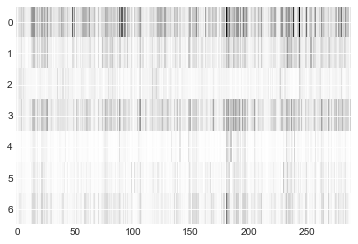

In [29]:
imagesc(b)

In [30]:
a

array([ 15,  24,  25,  27,  74,  83,  96, 107, 128, 148, 149, 181, 183,
       187, 188, 191, 197, 211, 233, 234, 235, 236, 237, 244, 251, 254,
       256, 263, 270], dtype=int64)

In [26]:
len(np.where(tmp >= np.percentile(tmp, 0.9))[0])

286

In [27]:
tmp.shape

(289,)

## Debugging

### IEG normalization

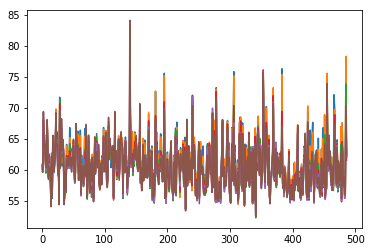

In [25]:
tmp = (get_Arc_expression(proj_meta, 1, 6))
plt.plot(tmp);
# Try a 8th-prctile normalization(smoothing) 
# look at ps-smooth function in matlab